# __1.3. Model performance and sharing__

Goal:
- Get performance information from saved model directories and plot it.
- Share model on hugging face.

Log:

## ___Setup___

In [2]:
import json, pickle
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from huggingface_hub import notebook_login
from transformers import BertForMaskedLM, AutoModel, BertTokenizerFast
from datasets import load_dataset


In [36]:
proj_dir  = Path.home() / "projects/plantbert"
work_dir  = proj_dir / "1_vanilla_bert"
model_dir = work_dir / "models/"               # compressed ckpt folders
ckpt_dir  = model_dir / "checkpoint-35500"     # ckpt folder
data_dir  = work_dir / "data"                  # data folder

## ___Determine progress using checkpoints___

In each checkpoint folder, there is a `trainer_state.json` file with info on:
- `epoch`
- `global step`
- `eval_steps`
- `log_history`: point to a list of dictionaries:
  - Traing dictionary with keys: 
    - `epoch`
    - `learning_rate``
    - `loss`
  - Evaluation dictionary:
    - `epoch`
    - `eval_loss`
  - Then the next traing/eval dicts of the next `epoch` value

### Parse `trainer_state.json`

- [Python tarfile doc](https://docs.python.org/3/library/tarfile.html)
- [Extract specific file from tar](https://stackoverflow.com/questions/35865099/python-extracting-specific-files-with-pattern-from-tar-gz-without-extracting-th)
- [Convert JSON to dictionary](https://www.geeksforgeeks.org/convert-json-to-dictionary-in-python/#)

In [5]:
log_dict = {} # {epoch: {train: loss, eval: loss}}

# extract file, note that this will be extracted to where the path was
# when the file is tarred. So, this is not right in the directory
# specified.
ts_file = ckpt_dir / "trainer_state.json"

# load json into a dictionary
trainer_state = json.load(open(ts_file, "r"))

# In the loaded dictionary, the key log_history points to a list with
#   training info in the odd elements,
#   evaluation info in the even elements.
for idx, log in enumerate(trainer_state["log_history"]):
  epoch = log['epoch']
  if idx % 2 == 0:
    loss = log['loss']
    log_dict[epoch] = {"train": loss}
  else:
    loss = log['eval_loss']
    log_dict[epoch]["eval"] = loss
    

In [8]:
log_df = pd.DataFrame.from_dict(log_dict, orient="index")
log_df.shape

(71, 2)

### Plot losses

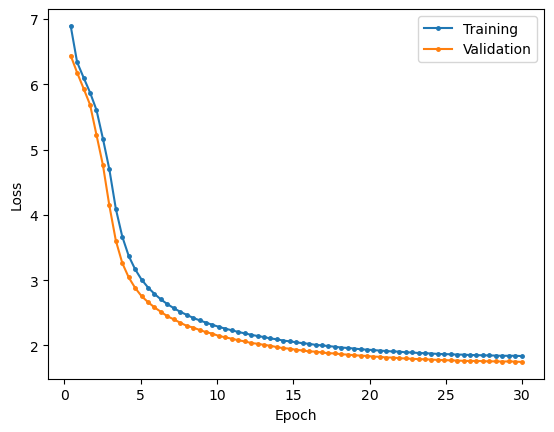

In [11]:
fig, ax = plt.subplots()
ax.plot(log_df.index, log_df["train"], marker=".", label="Training", markersize=5)
ax.plot(log_df.index, log_df["eval"], marker=".", label="Validation", markersize=5)
ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

plt.savefig(model_dir / "loss.pdf")

In [12]:
log_df.tail()

,train,eval
28.27,1.8444,1.756066
28.69,1.8414,1.753098
29.11,1.8417,1.755720
29.54,1.8419,1.751816
29.96,1.8376,1.747604


## ___Upload to Huggingface___

### Login to Hugging Face

See [share a model](https://huggingface.co/docs/transformers/model_sharing) on Hugging Face.
- [Get access token](https://huggingface.co/settings/tokens)
- Login with `huggingface-cli` in a terminal
  - Does not work in Jupyter notebook since it needs to be interactive.

In [16]:
#!huggingface-cli login

!huggingface-cli whoami

shius


In [18]:
# Get token from:
# https://huggingface.co/settings/tokens
notebook_login()

### Upload model

In [20]:
pt_model = BertForMaskedLM.from_pretrained(ckpt_dir)

In [27]:
pt_model.push_to_hub("plantbert-vanilla-cased")

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/shius/plantbert-vanilla-uncased/commit/85b61b8a9f7110ed940f214bd5dddd8ddad463f6', commit_message='Upload BertForMaskedLM', commit_description='', oid='85b61b8a9f7110ed940f214bd5dddd8ddad463f6', pr_url=None, pr_revision=None, pr_num=None)

### Upload tokenizer

In [28]:
tokenizer = BertTokenizerFast.from_pretrained(model_dir)

In [29]:
tokenizer.push_to_hub("plantbert-vanilla-cased")

CommitInfo(commit_url='https://huggingface.co/shius/plantbert-vanilla-uncased/commit/b727fe51ce0ad80a7a56bdc3d25b9d199f4502d3', commit_message='Upload tokenizer', commit_description='', oid='b727fe51ce0ad80a7a56bdc3d25b9d199f4502d3', pr_url=None, pr_revision=None, pr_num=None)

### Upload dataset

In [41]:
dataset_pkl_file = data_dir / "d_split.pickle"

with open(dataset_pkl_file, "rb") as f:
  dataset = pickle.load(f)

In [42]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 379176
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 42131
    })
})

In [43]:
dataset.push_to_hub("plantbert-vanilla-cased")

Pushing dataset shards to the dataset hub:   0%|          | 0/2 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/190 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/190 [00:00<?, ?ba/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/43 [00:00<?, ?ba/s]